In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
import shap
import re

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from tqdm import tqdm

from models.t0 import T0RegressionModel
from datahandles import TabLLMDataObject, FewshotTabLLMDataset, CombinedTabLLMTextDataset
from tabllm.dataset_utils import balance_dataset, load_and_preprocess_dataset
from utils import Config, ConfigObject, dict_to_mlp

os.environ["HF_HOME"] = "/export/pasan/.cache/huggingface"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/afs/glue.umd.edu/home/glue/p/a/pasand/home/miniconda3/envs/transhyper2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
checkpoint_path = f"save/t0pp-twotrain-bank-income-train005/epoch-12.pth"
checkpoint = torch.load(checkpoint_path, weights_only=False)
cfg = Config(cfg_dict=checkpoint["cfg"])
model = T0RegressionModel(cfg=cfg)
model.load_state_dict(checkpoint['model'])
tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer.model())

Hyponet mlp initialized with parameter shapes {'wb0': (104, 10), 'wb1': (11, 10), 'wb2': (11, 10), 'wb3': (11, 2)}
Initializing hypernet t0, name: t0, model: bigscience/T0pp
t0 hypernet hidden size: 4096
total hyponet params: 1282


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# Utils

In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, cmap='Blues'):
    """
    Displays a confusion matrix.

    Parameters:
    - y_true: list or array of true labels
    - y_pred: list or array of predicted labels
    - class_names: list of class names (optional)
    - normalize: whether to normalize the matrix (default: False)
    - cmap: color map for the heatmap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()



In [12]:
def swap_sentences(passage: str, permutation: list) -> str:
    """
    Swap two sentences in a structured passage while:
      - preserving original whitespace/newlines,
      - keeping the 'Example:' label at the very beginning,
      - not splitting on decimal points (e.g., 513.5),
      - not splitting on internal '?' like '... default? is no.',
      - leaving the QA section starting with 'Does this client' untouched.

    Indices are 0-based among sentences *after* the 'Example:' label.
    """
    # Split body vs QA (keep QA intact)
    m = re.match(r'(?is)^(.*?)(\n\s*Does this client.*)$', passage)
    if m:
        body, qa = m.group(1), m.group(2)
    else:
        body, qa = passage, ""

    # Keep the exact 'Example:' label (with its trailing whitespace) fixed at start
    m2 = re.match(r'(?is)^\s*(Example:\s*)(.*)$', body)
    if m2:
        prefix, rest = m2.group(1), m2.group(2)
    else:
        prefix, rest = "", body  # no Example: label present

    # Find sentences ending with a '.' that is NOT a decimal point (i.e., not between digits),
    # and include any following whitespace/newlines with each sentence.
    pattern = re.compile(r'''(?s)
        .*?                                # minimal content
        (?: (?<!\d)\. | \.(?!\d) )         # period not between digits
        \s*                                # keep trailing spaces/newlines
    ''', re.VERBOSE)

    sentences = [m.group(0) for m in pattern.finditer(rest)]
    tail = rest[pattern.search(rest).end():] if sentences else rest  # leftover (usually just whitespace)
    # More robust tail capture:
    last_end = 0
    for m in pattern.finditer(rest):
        last_end = m.end()
    tail = rest[last_end:]

    if len(permutation) < 1:
        # print("perm length 0")
        return passage
    
    len_diff = len(sentences) - max(permutation)
    if len_diff < 0:
        # print("len diff neg")
        return passage  # not enough sentences to swap
    
    permutation.extend(range(max(permutation)+1, len(sentences)))
    
    # Swap
    sentences = np.array(sentences)
    sentences = sentences[permutation]

    # Reassemble exactly
    new_body = f"{prefix}{''.join(sentences)}{tail}"
    return f"{new_body}{qa}"

# def swap_sentences(passage: str, permutation: list) -> str:
#     """
#     Swap two sentences in a passage while:
#       - preserving newlines and spacing
#       - keeping the 'Example:' prefix sentence always first
#       - leaving the QA section (Does this client...) untouched
#     """
#     # Separate descriptive part from QA part
#     match = re.match(r"^(.*?)(\n\s*Does this client.*)", passage, re.DOTALL | re.IGNORECASE)
#     if match:
#         body, qa = match.groups()
#     else:
#         body, qa = passage, ""
    
#     # Extract the "Example:" sentence (assume it ends at the first '.')
#     prefix_match = re.match(r'^(Example:)(.*)', body, re.DOTALL)
#     if prefix_match:
#         prefix, rest = prefix_match.groups()
#     else:
#         # No Example: prefix, just treat whole as body
#         prefix, rest = "", body
    
#     # Split the rest of sentences (excluding prefix), keeping punctuation and spacing
#     sentences = re.findall(r'[^.!?]*[.!?](?:\s+|$)', rest, re.DOTALL)
#     sentences = np.array([s for s in sentences if s.strip()])  # remove empties
    
#     if len(permutation) < 1:
#         # print("perm length 0")
#         return passage
    
#     len_diff = len(sentences) - max(permutation)
#     if len_diff < 0:
#         # print("len diff neg")
#         return passage  # not enough sentences to swap
    
#     permutation.extend(range(max(permutation)+1, len(sentences)))
    
#     # Swap
#     sentences = sentences[permutation]
    
#     # Rebuild passage
#     new_body = prefix + " " + "".join(sentences).lstrip()
    
#     return f"{new_body}{qa}"

class DS(CombinedTabLLMTextDataset):
    def __init__(self, ds, permutation):
        self.ds = ds
        self.permutation = permutation

    def __getitem__(self, index):
        item = self.ds[index]
        if isinstance(index, tuple):
            item = swap_sentences(item, self.permutation)
            # print("self.permutation", self.permutation)
        else:
            if len(self.permutation) < 1:
                return item
            len_diff = item["x"].shape[0] - max(self.permutation)
            if len_diff < 0:
                # print("len diff neg")
                return item  # not enough sentences to swap
            perm = []
            perm.extend(self.permutation)
            perm.extend(range(max(self.permutation) + 1, item["x"].shape[0]))
            item = {"x": item["x"][perm],
                    "y": item["y"]
            }

        return item
    
    def __len__(self):
        return len(self.ds)

In [13]:
def load_tabllm_datasets(train_list:list, test_list:list, balanced:dict, test_ratio:float, train_ratio:float, permutation:list=[]):
    cfg_dict = checkpoint["cfg"]
    cfg_dict["datasets"]["list_combine_test"] = test_list
    cfg_dict["datasets"]["list_combine_train"] = train_list
    cfg_dict["datasets"]["balanced"] = balanced
    cfg_dict["datasets"]["tabllm"]["txt_data_path"] = "tabllm/data/datasets_serialized"
    cfg_dict["datasets"]["test_ratio"] = test_ratio
    cfg_dict["datasets"]["train_ratio"] = train_ratio
    cfg_dict["datasets"]["test_size"] = ""
    cfg_dict["datasets"]["train_size"] = ""
    cfg_dict["debug"] = False
    cfg_dict["datasets"]["n_shots"] = 1
    cfg_dict["datasets"]["n_queries"] = 1
    cfg = Config(cfg_dict=cfg_dict)

    tabllm_do = TabLLMDataObject(cfg=cfg, set_hyponet_in_dim=False)
    test_ds = CombinedTabLLMTextDataset(cfg=cfg, 
                                        split="test", 
                                        datapoints=[tabllm_do.split_datapoints[ds_name] for ds_name in test_list],
                                        max_n_features=cfg.hyponet.in_dim())
    train_ds = CombinedTabLLMTextDataset(cfg=cfg, 
                                         split="train", 
                                         datapoints=[tabllm_do.split_datapoints[ds_name] for ds_name in train_list], 
                                         max_n_features=cfg.hyponet.in_dim())
    
    test_ds = DS(ds=test_ds, permutation=permutation)
    train_ds = DS(ds=train_ds, permutation=permutation)

    y_test = np.array([test_ds[i]["y"] for i in range(len(test_ds))])
    X_test = np.array([test_ds[i]["x"] for i in range(len(test_ds))])

    y_train = np.array([train_ds[i]["y"] for i in range(len(train_ds))])
    X_train = np.array([train_ds[i]["x"] for i in range(len(train_ds))])
    print(f"test_list: {test_list}, X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}\ntrain_list: {train_list}, X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
    return X_test, y_test, test_ds, X_train, y_train, train_ds

def get_hyponet_and_data(n_shots, ds_name, with_data=True):
    X_train, y_train, train_ds, X_test, y_test, test_ds = load_tabllm_datasets(train_list=["bank", "income"],
                                                                               test_list=[ds_name],
                                                                               balanced={"train": True, "val": False, "test": False},
                                                                               test_ratio=0.3,
                                                                               train_ratio=0.5)
    if n_shots > 0:
        prompt = "".join([test_ds[i, True] for i in np.random.randint(low=0, high=len(test_ds), size=n_shots)])
    else:
        prompt = "Quick brown fox jumped over the lazy dog!"
        
    tokens = tokenizer(prompt, 
                    truncation=cfg.tokenizer.truncation(), 
                    padding=cfg.tokenizer.padding(), 
                    max_length=cfg.tokenizer.max_length(), 
                    return_tensors='pt')
    if with_data:
        return model(tokens), X_test, y_test
    else:
        return model(tokens)
    
    
def get_hyponet(n_shots, test_ds):
    if n_shots > 0:
        prompt = "".join([test_ds[i, True] for i in np.random.randint(low=0, high=len(test_ds), size=n_shots)])
    else:
        prompt = "Quick brown fox jumped over the lazy dog!"
        
    tokens = tokenizer(prompt, 
                    truncation=cfg.tokenizer.truncation(), 
                    padding=cfg.tokenizer.padding(), 
                    max_length=cfg.tokenizer.max_length(), 
                    return_tensors='pt')

    return model(tokens)

In [11]:
X_train, y_train, train_ds, X_test, y_test, test_ds = load_tabllm_datasets(train_list=["bank", "income"],
                                                                               test_list=["calhousing"],
                                                                               balanced={"train": True, "val": False, "test": False},
                                                                               test_ratio=0.3,
                                                                               train_ratio=0.5)

test_list: ['calhousing'], X_test.shape: (6192, 103), y_test.shape: (6192,)
train_list: ['bank', 'income'], X_train.shape: (13882, 103), y_train.shape: (13882,)


# Hyponet layer-wise similarity

In [14]:
def get_layer_outputs(model, layers_to_hook):
    """
    Registers forward hooks on specified layers and returns a function to get their outputs.

    Args:
        model (nn.Module): The model to hook.
        layers_to_hook (list[str]): List of layer names (use model.named_modules()) to hook.

    Returns:
        - hook_handles: list of hook handles (for later removal).
        - get_outputs: function that takes an input and returns activations from hooked layers.
    """
    activations = OrderedDict()

    def hook_fn(name):
        def fn(module, input, output):
            # Flatten output for CKA computation: [batch_size, features]
            activations[name] = output.view(output.size(0), -1).detach()
        return fn

    hook_handles = []
    for name, module in model.named_modules():
        if name in layers_to_hook:
            handle = module.register_forward_hook(hook_fn(name))
            hook_handles.append(handle)

    def get_outputs(x):
        activations.clear()  # Clear before forward pass
        _ = model(x)
        return [activations[name] for name in layers_to_hook]

    return hook_handles, get_outputs

def center_kernel(K: np.ndarray) -> np.ndarray:
    """
    Center a kernel matrix using the double centering formula:
    K_c = K - 1K - K1 + 1K1
    """
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    return K_centered

def cka_matrix(X: np.ndarray, Y: np.ndarray) -> float:
    """
    Compute the Centered Kernel Alignment (CKA) between two sets of representations.
    
    Args:
        X: (n_samples, d1) activations/logits from model 1
        Y: (n_samples, d2) activations/logits from model 2
    
    Returns:
        Scalar CKA similarity between X and Y
    """
    Kx = X @ X.T
    Ky = Y @ Y.T
    
    Kx_centered = center_kernel(Kx)
    Ky_centered = center_kernel(Ky)
    
    numerator = np.sum(Kx_centered * Ky_centered)
    denominator = np.sqrt(np.sum(Kx_centered ** 2) * np.sum(Ky_centered ** 2))
    
    return numerator / denominator

def compute_cka_matrix_list(activations1: list[np.ndarray], activations2: list[np.ndarray]) -> np.ndarray:
    """
    Compute pairwise CKA between all activation matrices in a list.
    """
    n = len(activations1)
    print(f"number of activations: {n}")
    cka_mat = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            print(f"computing ({i},{j})-th element. {activations1[i].shape}, {activations2[i].shape}")
            cka_mat[i, j] = cka_matrix(activations1[i], activations2[j])
    
    return cka_mat

def plot_cka_matrix(cka_mat: np.ndarray, layer_names: list[str]=None, vmin: float=0.0, vmax: float=1.0) -> None:
    """
    Plot the CKA matrix using matplotlib.
    Shows values in the middle of each cell, rounded off to four decimal points.
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cka_mat, cmap="viridis", vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)

    # Show values in the middle of each cell, rounded to 4 decimal points
    for i in range(cka_mat.shape[0]):
        for j in range(cka_mat.shape[1]):
            ax.text(
                j, i, f"{cka_mat[i, j]:.4f}",
                ha="center", va="center",
                color="w" if cka_mat[i, j] < (vmin + vmax) / 2 else "black"
            )

    if layer_names is not None:
        ax.set_xticks(range(len(layer_names)))
        ax.set_yticks(range(len(layer_names)))
        ax.set_xticklabels(layer_names, rotation=90)
        ax.set_yticklabels(layer_names)
    else:
        ax.set_xticks(range(cka_mat.shape[0]))
        ax.set_yticks(range(cka_mat.shape[0]))

    ax.set_title("Centered Kernel Alignment (CKA)")
    plt.tight_layout()
    plt.show()

def load_cka_matrix(file):
    with open(file, 'rb') as f:
        print(f"loaded CKA matrix from {file}")
        return pickle.load(f)

def save_cka_matrix(file, matrix):
    with open(file, 'wb') as f:
        pickle.dump(matrix, f)
        print(f"saved CKA matrix to {file}")

def print_matrix(matrix):
    """
    Prints a 2D list/NumPy array with aligned columns.
    Floats are shown with 4 decimal places.
    """
    for row in matrix:
        print("  ".join(f"{val:.4f}" for val in row))


In [31]:
n_shots = 128
hyponet1, X1, y1 = get_hyponet_and_data(n_shots=n_shots, ds_name='calhousing')
hyponet2, X2, y2 = get_hyponet_and_data(n_shots=n_shots, ds_name='bank')
hyponet1.eval()
hyponet2.eval()

test_list: ['calhousing'], X_test.shape: (4128, 103), y_test.shape: (4128,)
train_list: ['bank', 'income'], X_train.shape: (13882, 103), y_train.shape: (13882,)
test_list: ['bank'], X_test.shape: (9043, 103), y_test.shape: (9043,)
train_list: ['bank', 'income'], X_train.shape: (13882, 103), y_train.shape: (13882,)


HypoMlp(
  (relu): ReLU()
)

In [32]:
mlp1 = dict_to_mlp(hyponet1.params, in_dim=X1.shape[1])
mlp2 = dict_to_mlp(hyponet2.params, in_dim=X2.shape[1])

layers = []
for i, m in mlp1.named_modules():
    layers.append(i)

print(f"layers: {layers}")
handles1, outputs1 = get_layer_outputs(mlp1, layers[1:])
handles2, outputs2 = get_layer_outputs(mlp2, layers[1:])

layers: ['', '0', '1', '2', '3', '4', '5', '6']


In [ ]:
acts1 = outputs1(torch.Tensor(X1))
acts2 = outputs2(torch.Tensor(X1))

matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1], 
                                     activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])
save_cka_matrix(f"./cka_matrix_data_cal_prompt_bank_n{n_shots}_blah.pkl", matrix)

/tmp/ipykernel_218450/2532481070.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1],
/tmp/ipykernel_218450/2532481070.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])


number of activations: 7
computing (0,0)-th element. (13882, 10), (13882, 10)
computing (0,1)-th element. (13882, 10), (13882, 10)
computing (0,2)-th element. (13882, 10), (13882, 10)
computing (0,3)-th element. (13882, 10), (13882, 10)
computing (0,4)-th element. (13882, 10), (13882, 10)
computing (0,5)-th element. (13882, 10), (13882, 10)
computing (0,6)-th element. (13882, 10), (13882, 10)
computing (1,0)-th element. (13882, 10), (13882, 10)
computing (1,1)-th element. (13882, 10), (13882, 10)
computing (1,2)-th element. (13882, 10), (13882, 10)
computing (1,3)-th element. (13882, 10), (13882, 10)
computing (1,4)-th element. (13882, 10), (13882, 10)
computing (1,5)-th element. (13882, 10), (13882, 10)
computing (1,6)-th element. (13882, 10), (13882, 10)
computing (2,0)-th element. (13882, 10), (13882, 10)
computing (2,1)-th element. (13882, 10), (13882, 10)
computing (2,2)-th element. (13882, 10), (13882, 10)
computing (2,3)-th element. (13882, 10), (13882, 10)
computing (2,4)-th el

In [ ]:
acts1 = outputs1(torch.Tensor(X1))
acts2 = outputs2(torch.Tensor(X2[:16513]))

matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1], 
                                     activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])
save_cka_matrix("./blah.pkl", matrix)

/tmp/ipykernel_3005732/3919453240.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1],
/tmp/ipykernel_3005732/3919453240.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])


number of activations: 7
computing (0,0)-th element. (16513, 10), (16513, 10)
computing (0,1)-th element. (16513, 10), (16513, 10)
computing (0,2)-th element. (16513, 10), (16513, 10)
computing (0,3)-th element. (16513, 10), (16513, 10)
computing (0,4)-th element. (16513, 10), (16513, 10)
computing (0,5)-th element. (16513, 10), (16513, 10)
computing (0,6)-th element. (16513, 10), (16513, 10)
computing (1,0)-th element. (16513, 10), (16513, 10)
computing (1,1)-th element. (16513, 10), (16513, 10)
computing (1,2)-th element. (16513, 10), (16513, 10)
computing (1,3)-th element. (16513, 10), (16513, 10)
computing (1,4)-th element. (16513, 10), (16513, 10)
computing (1,5)-th element. (16513, 10), (16513, 10)
computing (1,6)-th element. (16513, 10), (16513, 10)
computing (2,0)-th element. (16513, 10), (16513, 10)
computing (2,1)-th element. (16513, 10), (16513, 10)
computing (2,2)-th element. (16513, 10), (16513, 10)
computing (2,3)-th element. (16513, 10), (16513, 10)
computing (2,4)-th el

loaded CKA matrix from ./cka_matrix_data_cal_prompt_bank_n128.pkl
min: 0.9516640319949924, max: 1.0


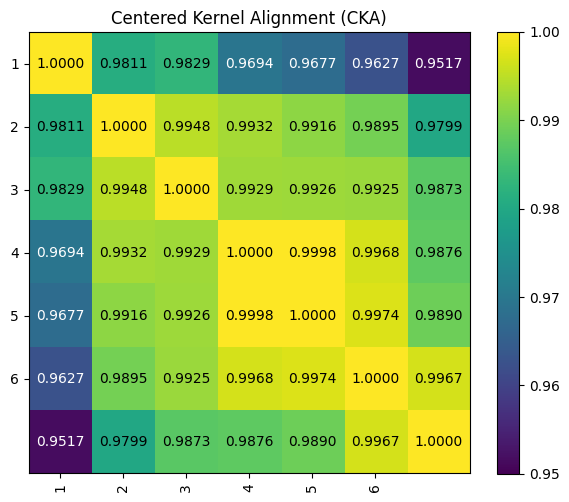

In [7]:
loaded_matrix = load_cka_matrix("./cka_matrix_data_cal_prompt_bank_n128.pkl")
print(f"min: {np.min(loaded_matrix)}, max: {np.max(loaded_matrix)}")
plot_cka_matrix(cka_mat=loaded_matrix, vmin=0.95, vmax=1, layer_names=range(1,7))

# Hyponet evaluate

In [15]:
def compute_metrics(cfg, n_shots, prompt_ds, X_test, y_test):
    if n_shots > 0:
        prompt = "".join([prompt_ds[i, True] for i in np.random.randint(low=0, high=len(prompt_ds), size=n_shots)])
    else:
        prompt = "Quick brown fox jumped over the lazy dog!"
        
    tokens = tokenizer(prompt, 
                    truncation=cfg.tokenizer.truncation(), 
                    padding=cfg.tokenizer.padding(), 
                    max_length=cfg.tokenizer.max_length(), 
                    return_tensors='pt')
    hyponet = model(tokens)
    hyponet.eval()
    preds = hyponet.forward(torch.Tensor(X_test).unsqueeze(dim=0))
    preds = preds.detach().numpy()
    preds = np.squeeze(preds)
    preds = np.argmax(preds, axis=1)

    val_counts = pd.DataFrame(y_test).value_counts()
    const_pred_acc = max(val_counts)/sum(val_counts) * 100
    balanced_acc = balanced_accuracy_score(y_test, preds) * 100
    f1 = f1_score(y_test, preds) * 100
    unbalanced_acc = accuracy_score(y_test, preds) * 100

    return {
        "preds": preds,
        "const_predictor_acc": const_pred_acc,
        "balanced_acc": balanced_acc,
        "f1_score": f1,
        "unbalanced_acc": unbalanced_acc
    }

In [ ]:
X_test, y_test, test_ds, _, _, _ = load_tabllm_datasets(train_list=["income", "bank"],
                                                        test_list=["calhousing"],
                                                        balanced={"train": True, "val": False, "test": False},
                                                        test_ratio=0.3,
                                                        train_ratio=0.5)

test_list: ['calhousing'], X_test.shape: (6192, 103), y_test.shape: (6192,)
train_list: ['calhousing', 'bank'], X_train.shape: (12316, 103), y_train.shape: (12316,)


In [10]:
test_ds[0, True]

'Example: The median income is 3.7440. The median age is 30. The total rooms is 1446. The total bedrooms is 385. The population is 650. The households is 344. The latitude is 32.80. The longitude is -117.26.\n\nIs this house block valuable? Yes or no? Answer:\n|||\nYes\n'

In [15]:
X_eval, y_eval, eval_ds, _, _, _ = load_tabllm_datasets(train_list=["bank", "income"],
                                                  test_list=["bank"],
                                                  balanced={"train": True, "val": False, "test": False},
                                                  test_ratio=0.3,
                                                  train_ratio=0.5)

test_list: ['bank'], X_test.shape: (13564, 103), y_test.shape: (13564,)
train_list: ['bank', 'income'], X_train.shape: (13882, 103), y_train.shape: (13882,)


In [16]:
eval_ds[0, True]

'Example: The age is 77. The type of job is retired. The marital status is married. The education is tertiary. The has credit in default? is no. The average yearly balance, in euros is 0. The has housing loan? is no. The has personal loan? is no. The contact communication type is cellular. The last contact day of the month is 6. The last contact month of year is apr. The last contact duration, in seconds is 190. The number of contacts performed during this campaign and for this client is. The number of days that passed by after the client was last contacted from a previous campaign is client was not previously contacted. The number of contacts performed before this campaign and for this client is 0. The outcome of the previous marketing campaign is unknown.\n\nDoes this client subscribe to a term deposit? Yes or no? Answer:\n|||\nNo\n'

In [13]:
balanced_acc = []
unbalanced_acc = []
f1 = []
# n_shots_list = [0, 4, 8, 16, 32, 64, 128, 256]
n_shots_list = [0, 1, 2, 4, 6, 8, 10]

for n_shots in n_shots_list:
    metrics = compute_metrics(cfg=cfg, n_shots=n_shots, prompt_ds=test_ds, X_test=X_test, y_test=y_test)
    balanced_acc.append(metrics['balanced_acc'])
    unbalanced_acc.append(metrics['unbalanced_acc'])
    f1.append(metrics['f1_score'])

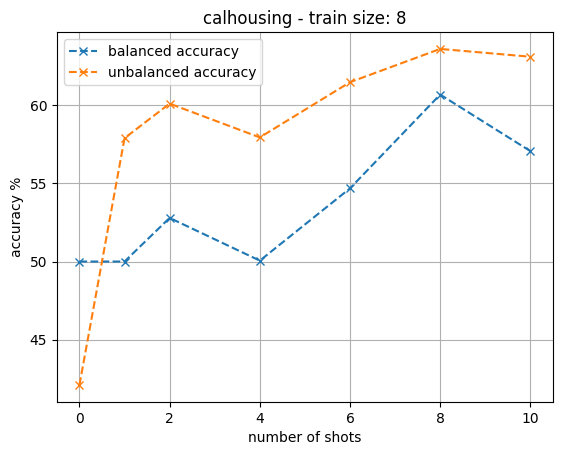

In [14]:
plt.plot(n_shots_list, balanced_acc, 'x--', label="balanced accuracy")
plt.plot(n_shots_list, unbalanced_acc, 'x--', label="unbalanced accuracy")
# plt.plot(n_shots_list, f1, 'x--', label="f1 score")
plt.title("calhousing - train size: 8")
plt.xlabel("number of shots")
plt.ylabel("accuracy %")
plt.grid(True)
plt.legend()
plt.show()

# Train raw MLP

In [16]:
def train_mlp_with_loaders(model, 
                           X_train, y_train, 
                           X_test, y_test, 
                           batch_size=32, 
                           epochs=20, 
                           lr=1e-3, 
                           device='cuda',
                           verbose=True,
                           show_plot=True):
    
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
    
    if not isinstance(X_test, torch.Tensor):
        X_test = torch.tensor(X_test, dtype=torch.float32)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
        

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Metric storage
    train_acc_list, val_acc_list = [], []
    train_bal_acc_list, val_bal_acc_list = [], []

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        # ---- Compute train metrics ----
        model.eval()
        train_true, train_pred = [], []
        with torch.no_grad():
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb).argmax(dim=1)
                train_true.extend(yb.cpu().numpy())
                train_pred.extend(preds.cpu().numpy())
        train_acc = accuracy_score(train_true, train_pred)
        train_bal_acc = balanced_accuracy_score(train_true, train_pred)

        # ---- Compute validation metrics ----
        val_true, val_pred = [], []
        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb).argmax(dim=1)
                val_true.extend(yb.cpu().numpy())
                val_pred.extend(preds.cpu().numpy())
        val_acc = accuracy_score(val_true, val_pred)
        val_bal_acc = balanced_accuracy_score(val_true, val_pred)

        # Store
        train_acc_list.append(train_acc)
        train_bal_acc_list.append(train_bal_acc)
        val_acc_list.append(val_acc)
        val_bal_acc_list.append(val_bal_acc)

        if verbose:
            tqdm.write(
                f"Epoch {epoch+1}/{epochs} "
                f"- Train Acc: {train_acc:.4f}, Train BalAcc: {train_bal_acc:.4f} "
                f"- Val Acc: {val_acc:.4f}, Val BalAcc: {val_bal_acc:.4f}"
            )

    # ---- Plot ----
    if show_plot:
        plt.figure(figsize=(10,5))
        plt.plot(range(1, epochs+1), train_acc_list, label='Train Accuracy', marker='x')
        plt.plot(range(1, epochs+1), val_acc_list, label='Val Accuracy', marker='x')
        plt.plot(range(1, epochs+1), train_bal_acc_list, label='Train Balanced Acc', marker='s')
        plt.plot(range(1, epochs+1), val_bal_acc_list, label='Val Balanced Acc', marker='s')
        plt.xlabel("Epoch")
        plt.ylabel("Score")
        plt.title("Train vs Validation Metrics per Epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "train_acc": train_acc_list,
        "train_bal_acc": train_bal_acc_list,
        "val_acc": val_acc_list,
        "val_bal_acc": val_bal_acc_list
    }

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, depth, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        layers = []
        layers.extend([nn.Linear(in_dim, hidden_dim), nn.ReLU(),])
        for _ in range(depth-2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.extend([nn.Linear(hidden_dim, out_dim), nn.ReLU()])
        self.model = nn.Sequential(*layers)

    def forward(self, X):
        return self.model(X)

In [16]:
# Load datasets
X_test, y_test, test_ds, X_train, y_train, train_ds = load_tabllm_datasets(train_list=["calhousing"],
                                                                           test_list=["calhousing"],
                                                                           balanced={"train": True, "val": False, "test": False},
                                                                           test_ratio=0.3,
                                                                           train_ratio=0.5)

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test, dtype=torch.long)

test_list: ['calhousing'], X_test.shape: (6192, 103), y_test.shape: (6192,)
train_list: ['calhousing'], X_train.shape: (10140, 103), y_train.shape: (10140,)


/tmp/ipykernel_1455402/3504345843.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_1455402/3504345843.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


Epoch 1/50 - Train Acc: 0.8218, Train BalAcc: 0.8218 - Val Acc: 0.7658, Val BalAcc: 0.7677


Epoch 2/50 - Train Acc: 0.8527, Train BalAcc: 0.8527 - Val Acc: 0.7952, Val BalAcc: 0.7887


Epoch 3/50 - Train Acc: 0.8567, Train BalAcc: 0.8567 - Val Acc: 0.7749, Val BalAcc: 0.7701


Epoch 4/50 - Train Acc: 0.8622, Train BalAcc: 0.8622 - Val Acc: 0.7855, Val BalAcc: 0.7758


Epoch 5/50 - Train Acc: 0.8628, Train BalAcc: 0.8628 - Val Acc: 0.7871, Val BalAcc: 0.7790


Epoch 6/50 - Train Acc: 0.8632, Train BalAcc: 0.8632 - Val Acc: 0.7941, Val BalAcc: 0.7860


Epoch 7/50 - Train Acc: 0.8634, Train BalAcc: 0.8634 - Val Acc: 0.7970, Val BalAcc: 0.7875


Epoch 8/50 - Train Acc: 0.8657, Train BalAcc: 0.8657 - Val Acc: 0.7800, Val BalAcc: 0.7726


Epoch 9/50 - Train Acc: 0.8621, Train BalAcc: 0.8621 - Val Acc: 0.7965, Val BalAcc: 0.7838


Epoch 10/50 - Train Acc: 0.8641, Train BalAcc: 0.8641 - Val Acc: 0.7817, Val BalAcc: 0.7747


Epoch 11/50 - Train Acc: 0.8618, Train BalAcc: 0.8618 - Val Acc: 0.7862, Val BalAcc: 0.7825


Epoch 12/50 - Train Acc: 0.8637, Train BalAcc: 0.8637 - Val Acc: 0.8060, Val BalAcc: 0.7958


Epoch 13/50 - Train Acc: 0.8666, Train BalAcc: 0.8666 - Val Acc: 0.7871, Val BalAcc: 0.7806


Epoch 14/50 - Train Acc: 0.8685, Train BalAcc: 0.8685 - Val Acc: 0.7913, Val BalAcc: 0.7810


Epoch 15/50 - Train Acc: 0.8688, Train BalAcc: 0.8688 - Val Acc: 0.7912, Val BalAcc: 0.7801


Epoch 16/50 - Train Acc: 0.8658, Train BalAcc: 0.8658 - Val Acc: 0.7875, Val BalAcc: 0.7797


Epoch 17/50 - Train Acc: 0.8674, Train BalAcc: 0.8674 - Val Acc: 0.7960, Val BalAcc: 0.7855


Epoch 18/50 - Train Acc: 0.8651, Train BalAcc: 0.8651 - Val Acc: 0.8014, Val BalAcc: 0.7888


Epoch 19/50 - Train Acc: 0.8672, Train BalAcc: 0.8672 - Val Acc: 0.7933, Val BalAcc: 0.7859


Epoch 20/50 - Train Acc: 0.8615, Train BalAcc: 0.8615 - Val Acc: 0.8078, Val BalAcc: 0.7940


Epoch 21/50 - Train Acc: 0.8673, Train BalAcc: 0.8673 - Val Acc: 0.8052, Val BalAcc: 0.7949


Epoch 22/50 - Train Acc: 0.8679, Train BalAcc: 0.8679 - Val Acc: 0.7859, Val BalAcc: 0.7796


Epoch 23/50 - Train Acc: 0.8663, Train BalAcc: 0.8663 - Val Acc: 0.7939, Val BalAcc: 0.7882


Epoch 24/50 - Train Acc: 0.8674, Train BalAcc: 0.8674 - Val Acc: 0.7813, Val BalAcc: 0.7743


Epoch 25/50 - Train Acc: 0.8689, Train BalAcc: 0.8689 - Val Acc: 0.7859, Val BalAcc: 0.7771


Epoch 26/50 - Train Acc: 0.8629, Train BalAcc: 0.8629 - Val Acc: 0.7907, Val BalAcc: 0.7835


Epoch 27/50 - Train Acc: 0.8691, Train BalAcc: 0.8691 - Val Acc: 0.7873, Val BalAcc: 0.7800


Epoch 28/50 - Train Acc: 0.8656, Train BalAcc: 0.8656 - Val Acc: 0.7766, Val BalAcc: 0.7740


Epoch 29/50 - Train Acc: 0.8657, Train BalAcc: 0.8657 - Val Acc: 0.7938, Val BalAcc: 0.7844


Epoch 30/50 - Train Acc: 0.8692, Train BalAcc: 0.8692 - Val Acc: 0.7930, Val BalAcc: 0.7858


Epoch 31/50 - Train Acc: 0.8647, Train BalAcc: 0.8647 - Val Acc: 0.7918, Val BalAcc: 0.7826


Epoch 32/50 - Train Acc: 0.8691, Train BalAcc: 0.8691 - Val Acc: 0.7964, Val BalAcc: 0.7880


Epoch 33/50 - Train Acc: 0.8689, Train BalAcc: 0.8689 - Val Acc: 0.7917, Val BalAcc: 0.7807


Epoch 34/50 - Train Acc: 0.8671, Train BalAcc: 0.8671 - Val Acc: 0.7754, Val BalAcc: 0.7720


Epoch 35/50 - Train Acc: 0.8688, Train BalAcc: 0.8688 - Val Acc: 0.7951, Val BalAcc: 0.7875


Epoch 36/50 - Train Acc: 0.8676, Train BalAcc: 0.8676 - Val Acc: 0.7878, Val BalAcc: 0.7816


Epoch 37/50 - Train Acc: 0.8684, Train BalAcc: 0.8684 - Val Acc: 0.7838, Val BalAcc: 0.7766


Epoch 38/50 - Train Acc: 0.8698, Train BalAcc: 0.8698 - Val Acc: 0.7854, Val BalAcc: 0.7772


Epoch 39/50 - Train Acc: 0.8703, Train BalAcc: 0.8703 - Val Acc: 0.7941, Val BalAcc: 0.7858


Epoch 40/50 - Train Acc: 0.8678, Train BalAcc: 0.8678 - Val Acc: 0.7928, Val BalAcc: 0.7878


Epoch 41/50 - Train Acc: 0.8682, Train BalAcc: 0.8682 - Val Acc: 0.7888, Val BalAcc: 0.7843


Epoch 42/50 - Train Acc: 0.8717, Train BalAcc: 0.8717 - Val Acc: 0.7913, Val BalAcc: 0.7839


Epoch 43/50 - Train Acc: 0.8701, Train BalAcc: 0.8701 - Val Acc: 0.7910, Val BalAcc: 0.7837


Epoch 44/50 - Train Acc: 0.8673, Train BalAcc: 0.8673 - Val Acc: 0.7829, Val BalAcc: 0.7764


Epoch 45/50 - Train Acc: 0.8694, Train BalAcc: 0.8694 - Val Acc: 0.7975, Val BalAcc: 0.7903


Epoch 46/50 - Train Acc: 0.8679, Train BalAcc: 0.8679 - Val Acc: 0.7871, Val BalAcc: 0.7834


Epoch 47/50 - Train Acc: 0.8652, Train BalAcc: 0.8652 - Val Acc: 0.7931, Val BalAcc: 0.7810


Epoch 48/50 - Train Acc: 0.8714, Train BalAcc: 0.8714 - Val Acc: 0.7883, Val BalAcc: 0.7794


Epoch 49/50 - Train Acc: 0.8664, Train BalAcc: 0.8664 - Val Acc: 0.7850, Val BalAcc: 0.7805


Epoch 50/50 - Train Acc: 0.8686, Train BalAcc: 0.8686 - Val Acc: 0.7917, Val BalAcc: 0.7856


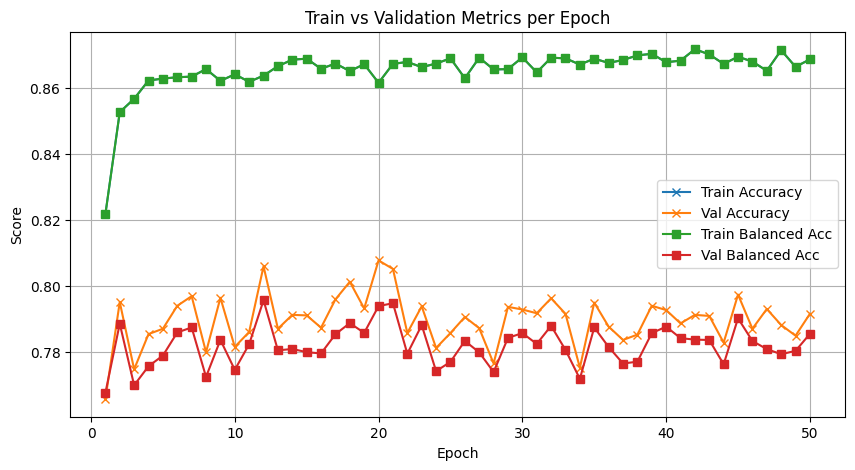

In [23]:
mlp = MLP(in_dim=103, hidden_dim=10, out_dim=2, depth=5)
n_cols_test = X_test.shape[1]
# perm = np.random.randint(low=0, high=n_cols_test, size=n_cols_test)
# perm = np.arange(n_cols_test)
metrics = train_mlp_with_loaders(model=mlp, 
                                 X_train=X_train, 
                                 y_train=y_train, 
                                 X_test=X_test, 
                                 y_test=y_test,
                                 epochs=50)

In [17]:
def shap_summary_plot_classification(model, X, feature_names=None, nsamples=100, device="cpu", class_idx=None):
    """
    Compute and plot SHAP summary plot for a PyTorch classification model.
    
    Works for binary (2 logits) and multi-class (C logits).
    
    Args:
        model (torch.nn.Module): Trained PyTorch model (output shape: [N, C]).
        X (np.ndarray or torch.Tensor): Input data.
        feature_names (list[str], optional): Feature names for labeling the plot.
        nsamples (int): Number of samples to explain (for efficiency).
        device (str): "cpu" or "cuda".
        class_idx (int or None): Which class to explain.
            - If None: defaults to 1 for binary classification, 0 for multi-class.
    
    Returns:
        shap_values: SHAP values (list if multi-class).
    """
    model.eval()
    model.to(device)

    # Convert to tensor if numpy
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    
    # Select subset for SHAP
    if X.shape[0] > nsamples:
        X_summary = X[:nsamples].to(device)
    else:
        X_summary = X.to(device)

    # Prediction wrapper: return probabilities
    def f(x):
        with torch.no_grad():
            logits = model(torch.tensor(x, dtype=torch.float32).to(device))  # convert back to tensor
            probs = torch.softmax(logits, dim=1)     # [N, C]
            return probs.detach().cpu().numpy()

    # Explicit masker for tabular data
    masker = shap.maskers.Independent(X_summary.cpu().numpy())

    # SHAP Explainer
    explainer = shap.Explainer(f, masker)
    shap_values = explainer(X_summary.cpu().numpy())

    # Decide default class_idx
    num_classes = shap_values.values.shape[-1]
    if class_idx is None:
        class_idx = 1 if num_classes == 2 else 0

    # Extract SHAP values for chosen class
    class_shap = shap_values[:, :, class_idx]

    # Plot summary
    plt.figure(figsize=(10, 5))
    shap.summary_plot(
        class_shap,
        X_summary.cpu().numpy(),
        feature_names=feature_names,
        show=True
    )

    return shap_values

/tmp/ipykernel_903035/1736552688.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


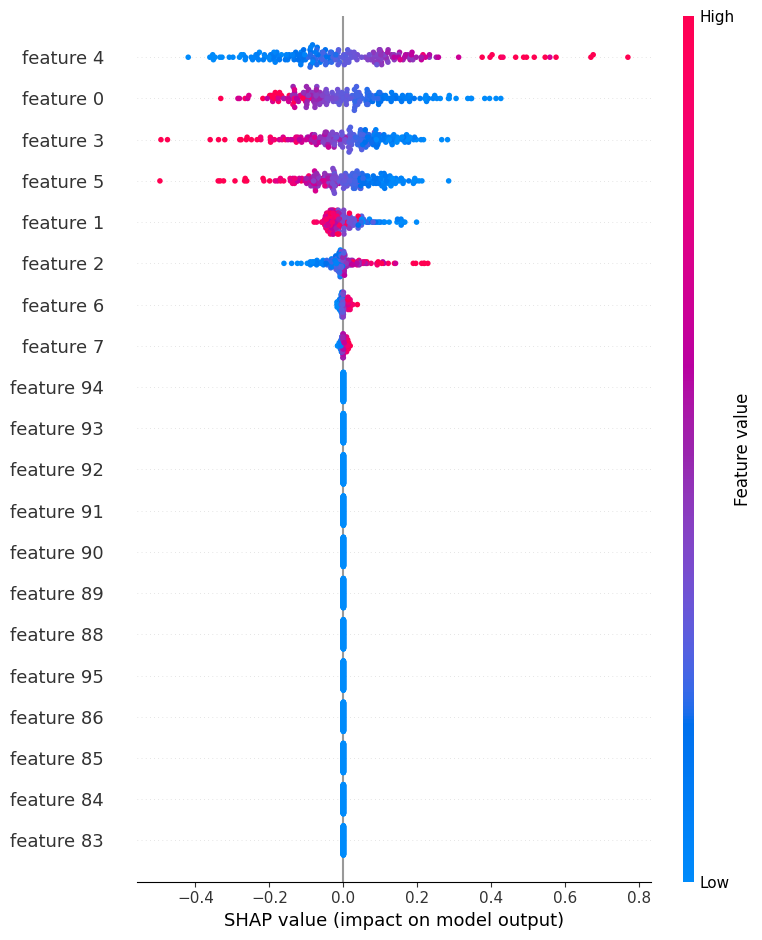

In [69]:
shap_values = shap_summary_plot_classification(
    model=mlp,
    X=X_test,
    feature_names=[f"feature {i}" for i in range(X_test.shape[1])],
    nsamples=200,
    class_idx=0  # positive class
)

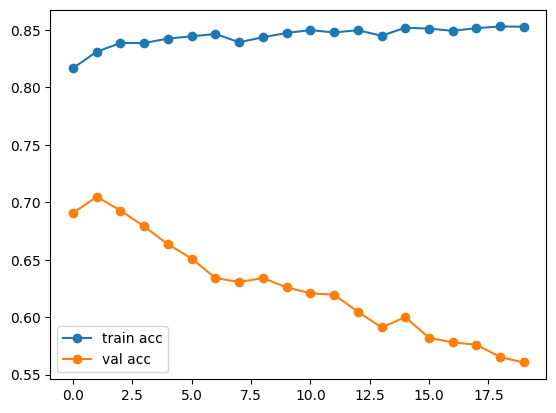

In [13]:
plt.plot(metrics["train_acc"], label="train acc", marker="o")
plt.plot(metrics["val_acc"], label="val acc", marker="o")
plt.legend()

# MLPs vs hyponets: SHAP

In [18]:
ds1_name = "calhousing"
ds2_name = "calhousing"
n_shots = 100
train_ratio = 0.5
test_ratio = 0.3

In [19]:
X1_train, y1_train, train_ds1, X1_test, y1_test, test_ds1 = load_tabllm_datasets(train_list=[ds1_name],
                                                                           test_list=[ds1_name],
                                                                           balanced={"train": True, "val": False, "test": False},
                                                                           test_ratio=test_ratio,
                                                                           train_ratio=train_ratio)

test_list: ['calhousing'], X_test.shape: (6192, 103), y_test.shape: (6192,)
train_list: ['calhousing'], X_train.shape: (10140, 103), y_train.shape: (10140,)


In [26]:
X2_train, y2_train, train_ds2, X2_test, y2_test, test_ds2 = load_tabllm_datasets(train_list=[ds2_name],
                                                                           test_list=[ds2_name],
                                                                           balanced={"train": True, "val": False, "test": False},
                                                                           test_ratio=test_ratio,
                                                                           train_ratio=train_ratio,
                                                                           permutation=[6, 0])

test_list: ['calhousing'], X_test.shape: (6192, 98), y_test.shape: (6192,)
train_list: ['calhousing'], X_train.shape: (10140, 98), y_train.shape: (10140,)


In [27]:
print(test_ds1[1, True])
print(test_ds2[1, True])

Example: The median income is 2.2708. The median age is 34. The total rooms is 1765. The total bedrooms is 551. The population is 2203. The households is 500. The latitude is 34.07. The longitude is -118.20.

Is this house block valuable? Yes or no? Answer:
|||
No

Example: The latitude is 34.07. The median income is 2.2708. The longitude is -118.20.

Is this house block valuable? Yes or no? Answer:
|||
No



In [ ]:
mlp1 = MLP(in_dim=103, hidden_dim=10, out_dim=2)
metrics1 = train_mlp_with_loaders(model=mlp1, 
                                 X_train=X1_train, 
                                 y_train=y1_train, 
                                 X_test=X1_test, 
                                 y_test=y1_test,
                                 epochs=30,
                                 verbose=False,
                                 show_plot=False)

Epoch [1/30]:   0%|          | 0/194 [00:00<?, ?it/s]

In [12]:
mlp2 = MLP(in_dim=103, hidden_dim=10, out_dim=2)
metrics2 = train_mlp_with_loaders(model=mlp2, 
                                 X_train=X2_train, 
                                 y_train=y2_train, 
                                 X_test=X2_test, 
                                 y_test=y2_test,
                                 epochs=30,
                                 verbose=False,
                                 show_plot=False)

In [23]:
hyponet1 = get_hyponet(n_shots=n_shots, test_ds=test_ds1)
hyponet2 = get_hyponet(n_shots=n_shots, test_ds=test_ds2)

hyp_mlp1 = dict_to_mlp(hyponet1.params, in_dim=103)
hyp_mlp2 = dict_to_mlp(hyponet2.params, in_dim=103)

PermutationExplainer explainer: 201it [00:13,  8.64it/s]                         
/tmp/ipykernel_1161175/1736552688.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


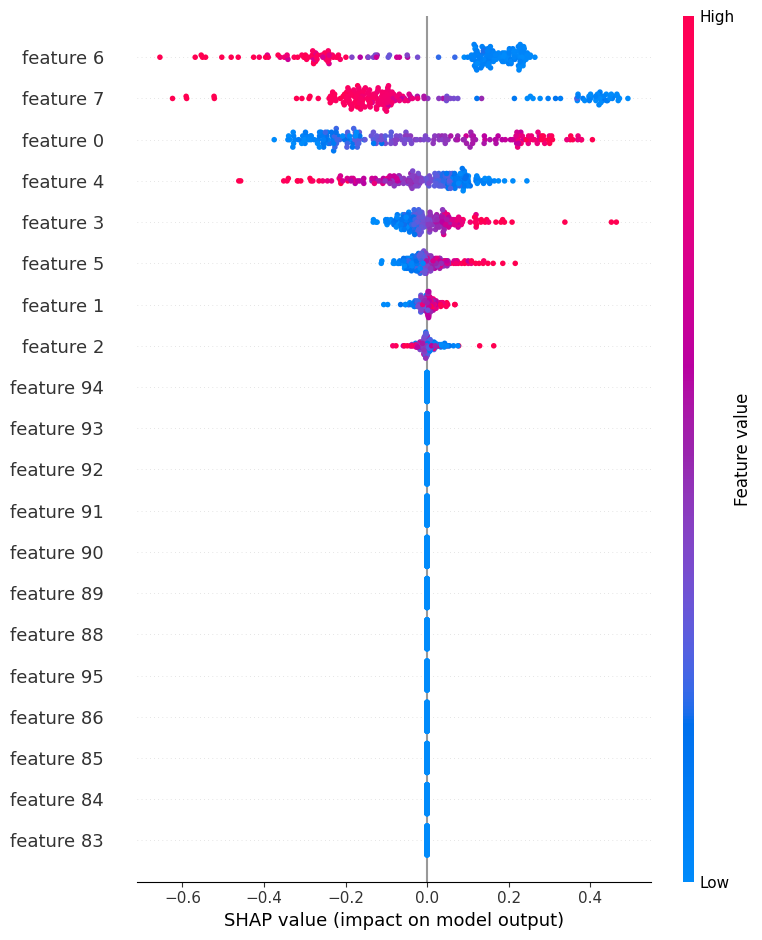

In [14]:
shap_values = shap_summary_plot_classification(
    model=mlp1,
    X=X1_test,
    feature_names=[f"feature {i}" for i in range(X1_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)

/tmp/ipykernel_1161175/1736552688.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


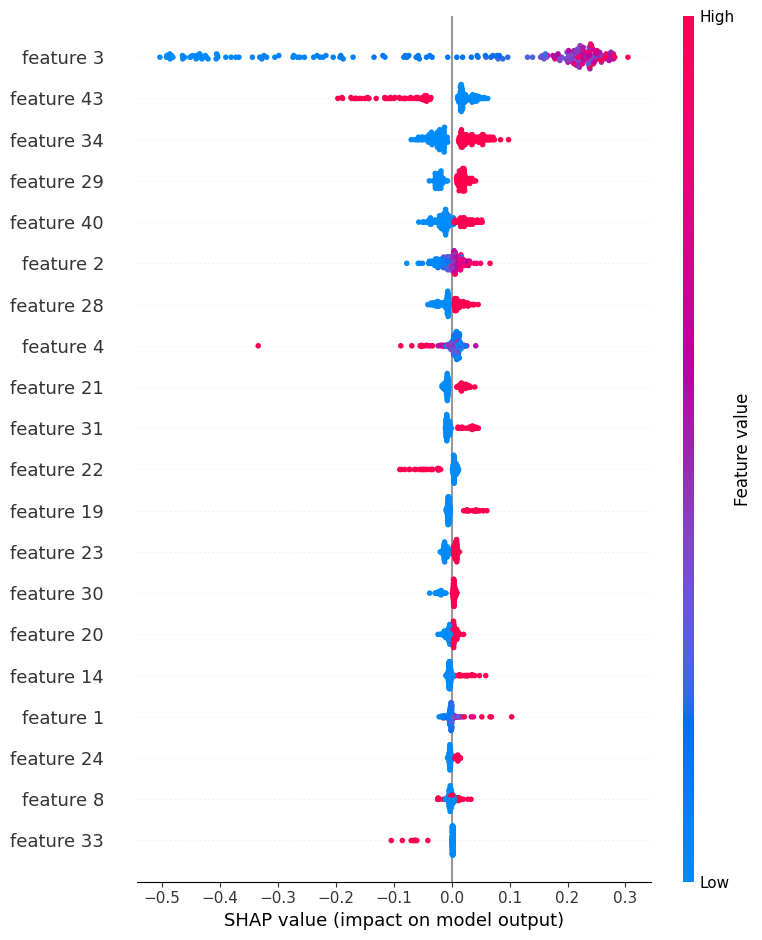

In [15]:
shap_values = shap_summary_plot_classification(
    model=mlp2,
    X=X2_test,
    feature_names=[f"feature {i}" for i in range(X2_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)

/tmp/ipykernel_1161175/1736552688.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


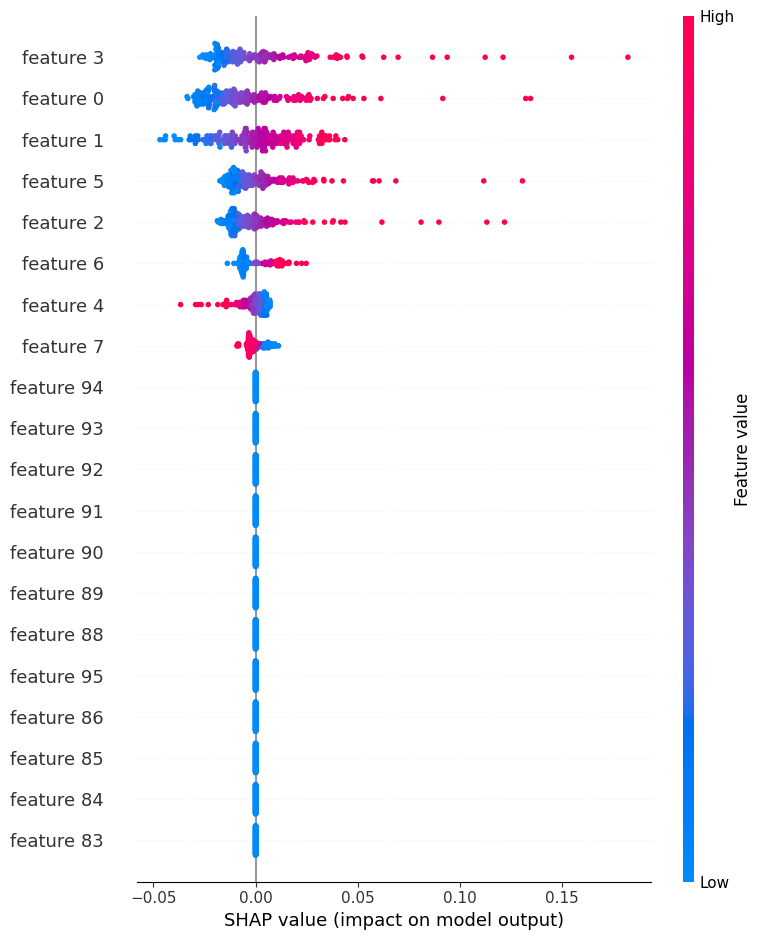

In [16]:
shap_values = shap_summary_plot_classification(
    model=hyp_mlp1,
    X=X1_test,
    feature_names=[f"feature {i}" for i in range(X1_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)

/tmp/ipykernel_1161175/1736552688.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


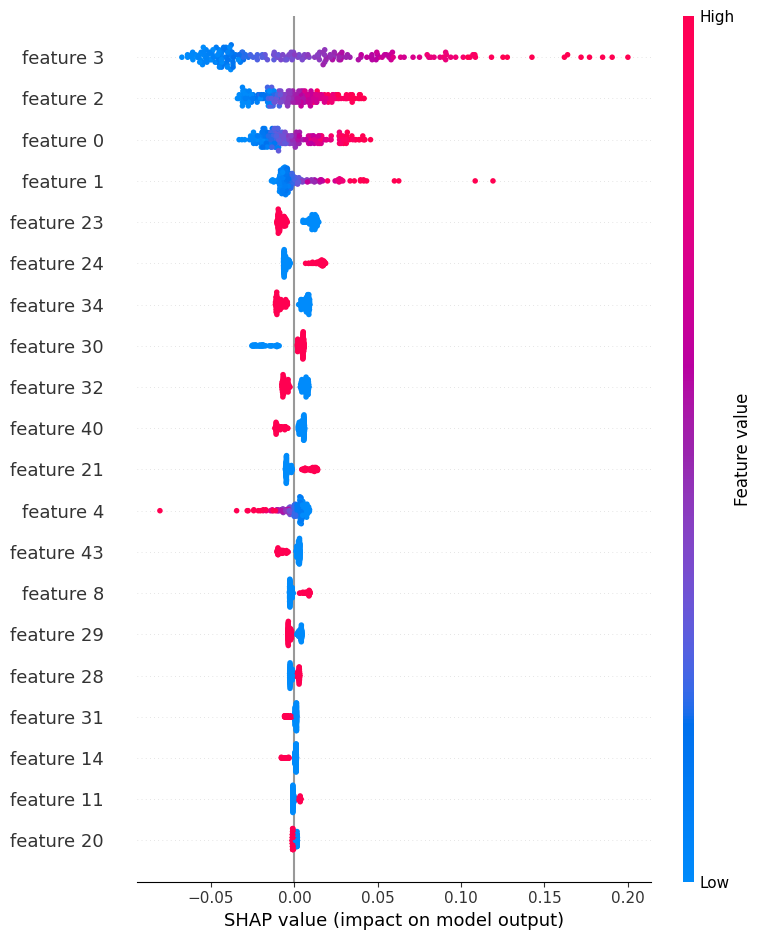

In [17]:
shap_values = shap_summary_plot_classification(
    model=hyp_mlp2,
    X=X2_test,
    feature_names=[f"feature {i}" for i in range(X2_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)

PermutationExplainer explainer: 201it [00:13,  8.09it/s]                         
/tmp/ipykernel_1478860/801892214.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


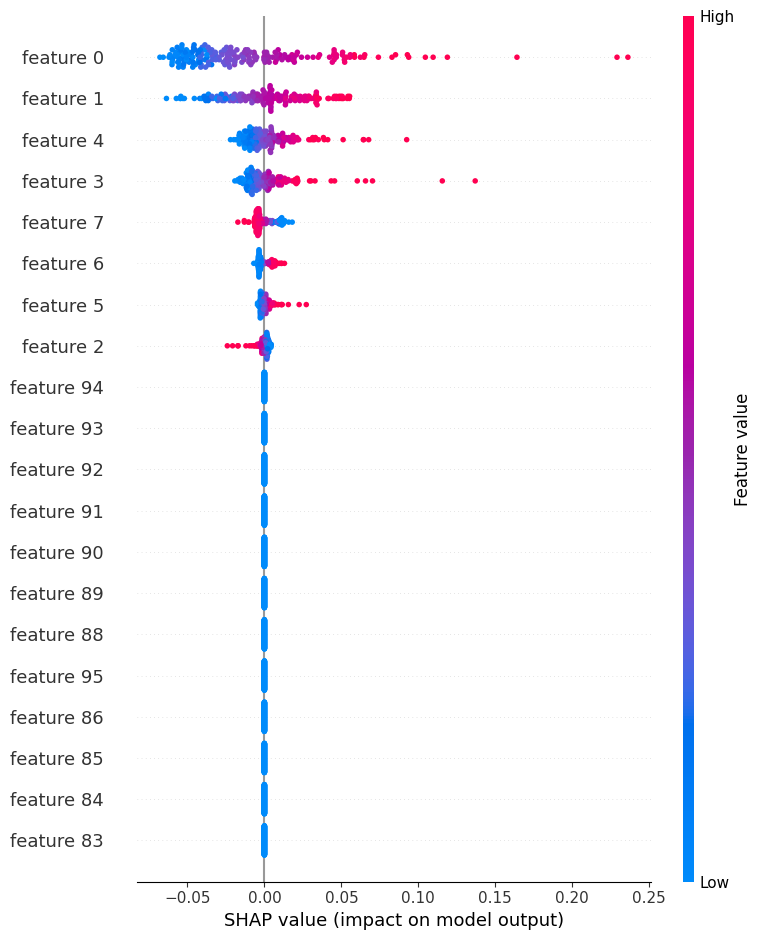

In [24]:
shap_values = shap_summary_plot_classification(
    model=hyp_mlp1,
    X=X1_test,
    feature_names=[f"feature {i}" for i in range(X1_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)

/tmp/ipykernel_1478860/801892214.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


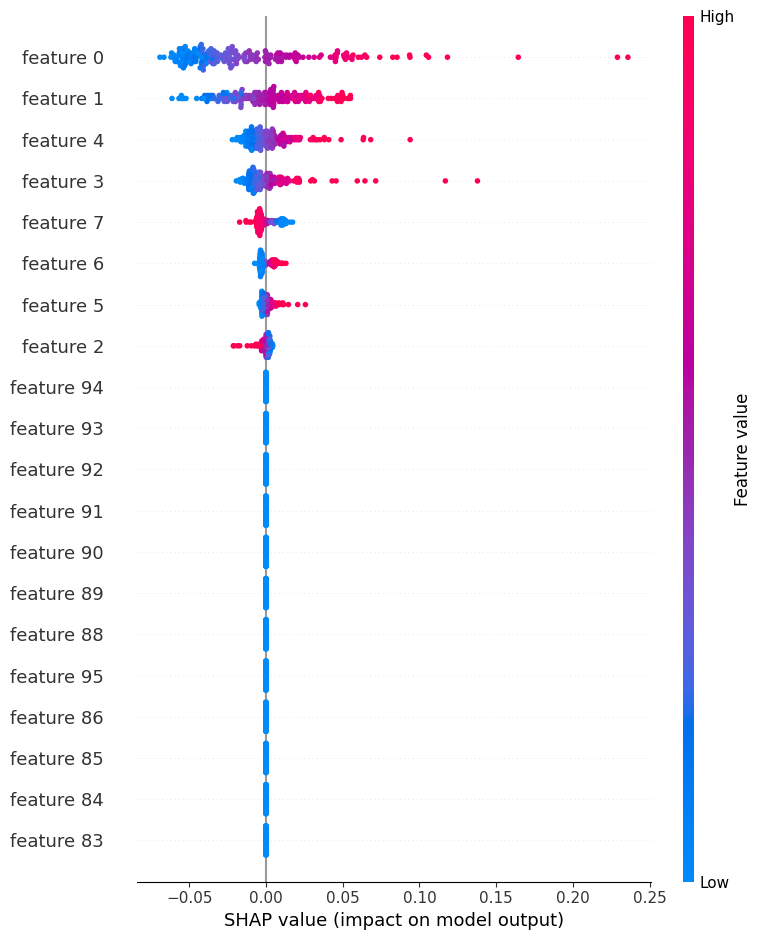

In [25]:
shap_values = shap_summary_plot_classification(
    model=hyp_mlp2,
    X=X1_test,
    feature_names=[f"feature {i}" for i in range(X1_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)

/tmp/ipykernel_1161175/1736552688.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


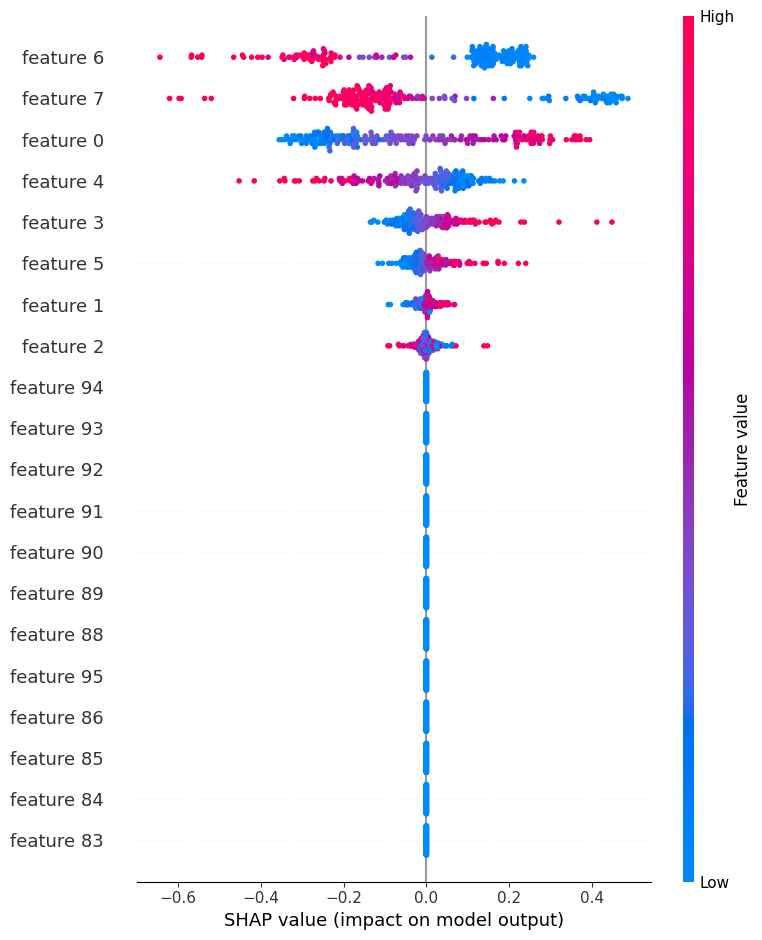

In [20]:
shap_values = shap_summary_plot_classification(
    model=mlp1,
    X=X1_test,
    feature_names=[f"feature {i}" for i in range(X1_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)

/tmp/ipykernel_1161175/1736552688.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


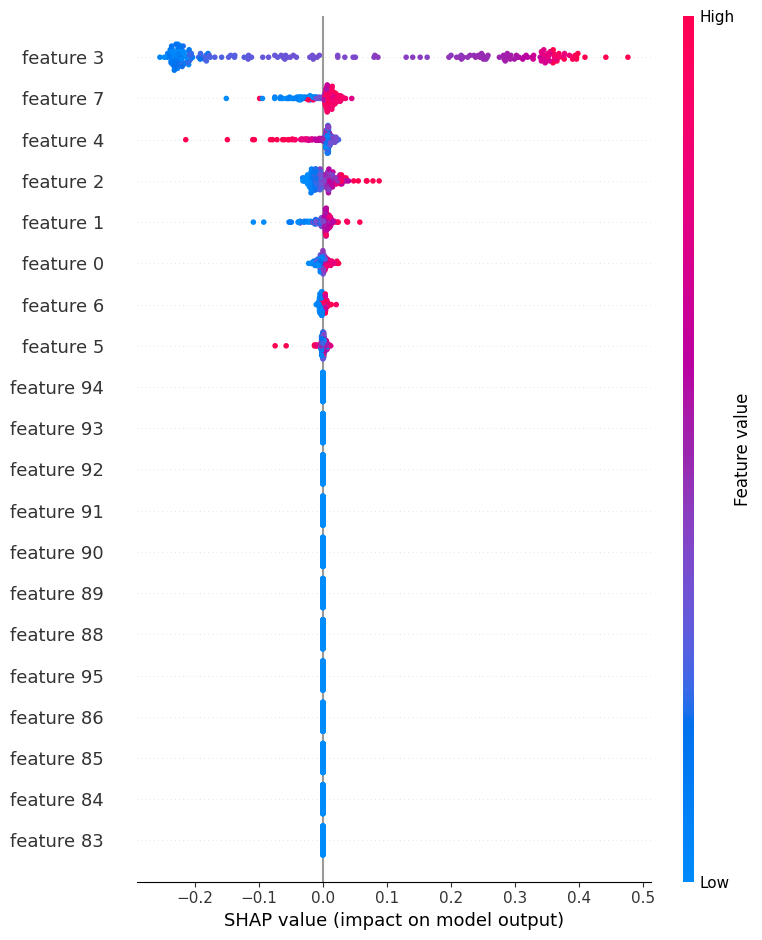

In [21]:
shap_values = shap_summary_plot_classification(
    model=mlp2,
    X=X1_test,
    feature_names=[f"feature {i}" for i in range(X1_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)

/tmp/ipykernel_1161175/1736552688.py:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


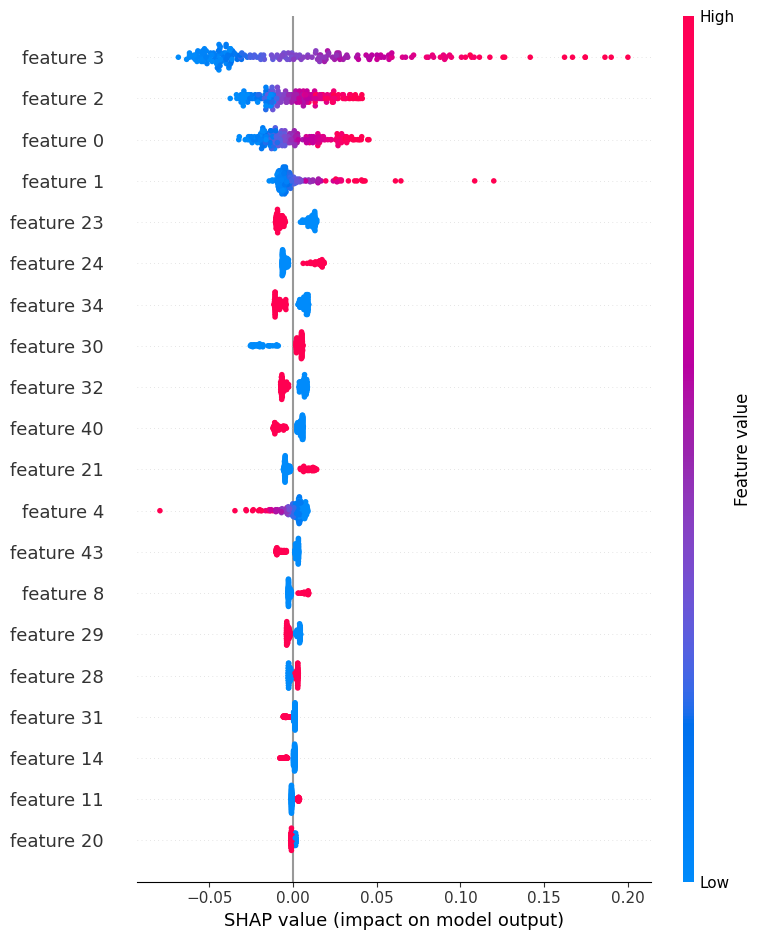

In [22]:
shap_values = shap_summary_plot_classification(
    model=hyp_mlp1,
    X=X2_test,
    feature_names=[f"feature {i}" for i in range(X2_test.shape[1])],
    nsamples=200,
    class_idx=1  # positive class
)